In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.utils import Sequence


from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor

import random

In [2]:
TARGET_SIZE = (144, 256)

In [3]:
def parse_filename(filename):
    components = filename.split("_")
    offset = 0
    
    if "-" in components[1]:
        offset = 1
    
    if len(components) < 6 + offset:
        return False, []
   
    x = int(components[1 + offset])
    y = int(components[2 + offset])
    z = int(components[3 + offset])
    r = int(components[4 + offset])
    is_flying = int(components[5 + offset].split(".")[0])

    if x == 0 and y == 0 and z == 0 and r == 0:
        return False, []

    # flip the z and x due to data-record error
    return True, [z, y, x, r, is_flying]

In [4]:
image_data = []
label_data = []

for date_folder in os.listdir("data"):
    date_folder_path = os.path.join("data", date_folder)

    if os.path.isdir(date_folder_path):
        for filename in os.listdir(date_folder_path):
            if filename.endswith(".png"):
                image_path = os.path.join(date_folder_path, filename)
                valid, components = parse_filename(filename)
                
                if valid:
                    image_data.append(image_path)
                    label_data.append(components)

In [5]:
label_tuples = [tuple(label) for label in label_data]
label_counter = Counter(label_tuples)

In [6]:
min_occurrences = 100
f_label_data = [label_data[i] for i, label in enumerate(label_data) if label_counter[tuple(label)] >= min_occurrences]
f_image_data = [image_data[i] for i, label in enumerate(label_data) if label_counter[tuple(label)] >= min_occurrences]

f_label_tuples = [tuple(label) for label in f_label_data]
f_label_counter = Counter(f_label_tuples)

sorted_labels = sorted(f_label_counter.items(), key=lambda x: x[1], reverse=True)

second_most_common_label = sorted_labels[1][0]
second_most_common_label_count = sorted_labels[1][1]
most_common_label = sorted_labels[0][0]
most_common_label_count = sorted_labels[0][1]

difference = most_common_label_count - second_most_common_label_count

In [7]:
removed_count = 0

e_label_data = []
e_image_data = []

for i, label in enumerate(f_label_data):
    if tuple(label) != most_common_label:
        e_label_data.append(label)
        e_image_data.append(f_image_data[i])
    elif tuple(label) == most_common_label and removed_count <= difference:
        removed_count += 1

        e_label_data.append(label)
        e_image_data.append(f_image_data[i])

In [8]:
tokenizer = {label: idx for idx, (label, _) in enumerate(sorted_labels)}
detokenizer = {idx: label for idx, (label, _) in enumerate(sorted_labels)}

tokenized_labels = [tokenizer[tuple(label)] for label in e_label_data]

In [9]:
print(len(label_data), len(image_data), len(e_label_data), len(e_image_data))

5708 5708 4985 4985


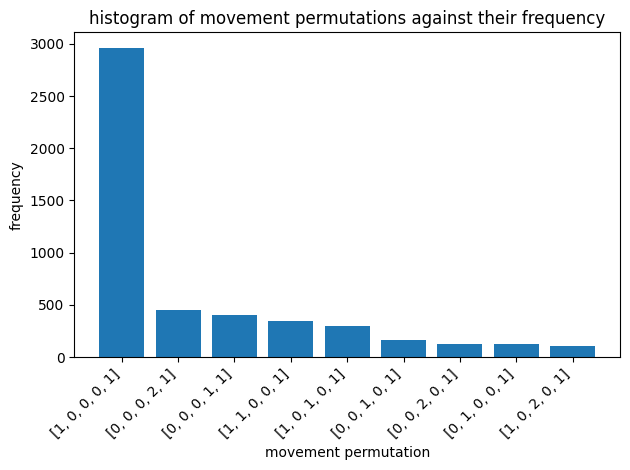

In [10]:
frequencies, bins = np.histogram(tokenized_labels, bins=len(sorted_labels))

plt.bar(range(len(sorted_labels)), frequencies)

plt.xlabel("movement permutation")
plt.ylabel("frequency")
plt.title("histogram of movement permutations against their frequency")

num_of_labels = 1

x_labels = [f"[{x}, {y}, {z}, {r}, {is_flying}]" for (x, y, z, r, is_flying), _ in sorted_labels]
plt.xticks(range(0, len(sorted_labels), num_of_labels), x_labels[::num_of_labels], rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
def preprocess_image(image_path):
    image = load_img(image_path, target_size=TARGET_SIZE) 
    image = img_to_array(image) / 255.0

    return image

In [ ]:
def preprocess_and_cache_images(image_paths, cache_folder, max_workers):
    os.makedirs(cache_folder, exist_ok=True)
    cached_images = []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for image_path in image_paths:
            cached_path = os.path.join(cache_folder, os.path.basename(image_path) + ".npy")
            if os.path.exists(cached_path):
                cached_images.append(np.load(cached_path))
            else:
                image = preprocess_image(image_path)
                np.save(cached_path, image)
                cached_images.append(cached_path)

    return cached_images

In [ ]:
f_image_data = preprocess_and_cache_images(f_image_data, "cache", max_workers=os.cpu_count())
one_hot_labels = tf.keras.utils.to_categorical(tokenized_labels, num_classes=len(f_label_counter))

In [ ]:
print(len(label_data), len(image_data), len(f_label_data), len(f_image_data))

In [ ]:
image_train, image_val, label_train, label_val = train_test_split(
    f_image_data, one_hot_labels, test_size=0.2, random_state=42)

# convert to np array and print shape
image_train = np.array(image_train)
image_val = np.array(image_val)
label_train = np.array(label_train)
label_val = np.array(label_val)
print(image_train.shape, image_val.shape, label_train.shape, label_val.shape)

In [ ]:
# make a CNN
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(len(f_label_counter), activation="softmax"))

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    image_train,
    label_train,
    epochs=10,
    batch_size=32,
    validation_data=(image_val, label_val)
)

In [ ]:
def predict(filename, from_folder=False):
    image = None

    if from_folder:
        image = preprocess_image(filename)

    image = np.expand_dims(image or filename, axis=0)

    if not from_folder:
        plt.imshow(image[0])

    predictions = model.predict(image)[0]
    predictions = np.argmax(predictions)

    result = detokenizer[predictions]

    return result


In [ ]:
def command_to_english(command):
    output = "the drone should "
    mapping = {
        1: {
            1: "move forward",
            2: "move backward"
        },
        2: {
            1: "move up",
            2: "move down"
        },
        3: {
            1: "move left",
            2: "move right"
        },
        4: {
            1: "rotate right",
            2: "rotate left"
        },
        5: {
            1: "be flying",
            2: "landing"
        }
    }

    for i in range(len(command)):
        if command[i] != 0 and command[i] in mapping[i+1]:
            output += mapping[i+1][command[i]] + " and "
    
    return output[:-5]
    

In [ ]:
ran_index = random.randint(0, len(image_val))
predictions = predict(image_val[ran_index], from_folder=False)
label = label_val[ran_index]

print(f"predictions | {predictions}")
print(f"label       | {detokenizer[np.argmax(label)]}")
print(f"meaning     | {command_to_english(predictions)}")

In [ ]:
# model.save("models/VA75_8-14-23_overfit.h5")